# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to **combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type**. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, **a user can receive an offer, never actually view the offer, and still complete the offer.** For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. **You'll want to try to assess what a certain demographic group will buy when not receiving any offers.**

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could **build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer**. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [2]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score
import warnings

# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

In [237]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [238]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [239]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


## Data Assessing

### Portfolio

In [240]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [241]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


### Profile

In [242]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [243]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


Text(0.5, 0, 'Age')

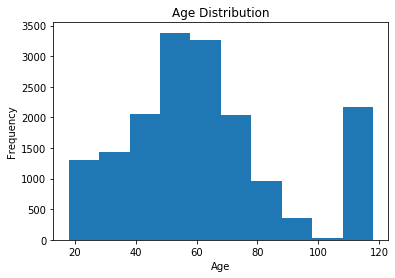

In [244]:
profile.age.plot(kind='hist')
plt.title('Age Distribution')
plt.xlabel('Age')

**Strange distribution of age with a massive spike at well over 100.**

In [245]:
profile[profile['age'] == 118].shape[0]

2175

In [246]:
profile.gender.isna().sum(), profile.income.isna().sum()

(2175, 2175)

In [247]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


**Seems like the same users who inputted their age as 118 also didn't input their gender or income.**

**118 is therefore likely the default age that is entered when the user doesn't select any.**

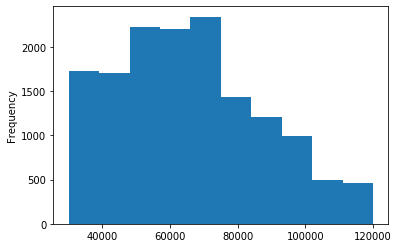

In [248]:
profile.income.plot(kind='hist')

In [249]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [250]:
profile.duplicated().sum()

0

### Transcript

In [251]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [252]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [253]:
transcript.time.describe()

count    306534.000000
mean        366.382940
std         200.326314
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64

In [254]:
transcript.value

0         {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2         {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4         {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
                                ...                       
306529                      {'amount': 1.5899999999999999}
306530                                    {'amount': 9.53}
306531                                    {'amount': 3.61}
306532                      {'amount': 3.5300000000000002}
306533                                    {'amount': 4.05}
Name: value, Length: 306534, dtype: object

In [255]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

## Data Cleaning

### Cleaning - Portfolio

In [256]:
df_offer = portfolio.copy()

In [257]:
df_offer.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


**Rename id column to offer_id.**

In [258]:
df_offer.rename(columns={'id':'offer_id'}, inplace=True)

In [259]:
# check for validity
df_offer.head(1)

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd


**Convert channels column to one-hot encoded columns.**

In [260]:
dummies = pd.get_dummies(df_offer.channels.apply(pd.Series).stack()).sum(level=0)
df_offer = pd.concat([df_offer, dummies], axis=1)
df_offer = df_offer.drop(columns='channels')

In [261]:
df_offer

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


**Convert offer_type column to one-hot encoded columns.**

In [263]:
dummies = pd.get_dummies(df_offer.offer_type)
df_offer = pd.concat([df_offer, dummies], axis=1)

In [264]:
df_offer

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web,bogo,discount,informational,bogo,discount,informational
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0,1,0,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0,1,0,0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1,0,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0,1,0,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0,0,1,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0,0,1,0
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0,0,1,0
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1,0,0,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0,1,0,0
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0,0,1,0


**Change duration title to duration_days for clarity in further analysis.**

In [265]:
df_offer.rename(columns={'duration':'duration_days','difficulty':'min_spend'}, inplace=True)

In [266]:
df_offer

,reward,min_spend,duration_days,offer_type,offer_id,email,mobile,social,web,bogo,discount,informational,bogo,discount,informational
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0,1,0,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0,1,0,0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1,0,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0,1,0,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0,0,1,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0,0,1,0
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0,0,1,0
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1,0,0,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0,1,0,0
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0,0,1,0


### Cleaning - Profile

In [267]:
df_user = profile.copy()

In [268]:
df_user.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


**Remove all null rows as income, gender and 118 age are all found in the same rows.**

In [33]:
df_user.dropna(inplace = True)

In [34]:
# check dataframe
df_user.head()

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0


In [35]:
# check for any null values remaining
df_user.isna().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

**Change became_member_on column from string to datetime.**

In [36]:
df_user['became_member_on'] = pd.to_datetime(df_user['became_member_on'], format='%Y%m%d')

In [37]:
# check dtype has changed to datetime
df_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  object        
 1   age               14825 non-null  int64         
 2   id                14825 non-null  object        
 3   became_member_on  14825 non-null  datetime64[ns]
 4   income            14825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 694.9+ KB


In [38]:
# visually asses datetime change
df_user.head()

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0


**Change id to user_id.**

In [39]:
df_user.rename(columns={'id':'user_id'}, inplace=True)

In [40]:
# check column name change
df_user.head()

,gender,age,user_id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0


**Create age bins for later classification analysis.**

In [41]:
df_user.loc[(df_user.age < 20) , 'Age_group'] = 'Under 20'
df_user.loc[(df_user.age >= 20) & (df_user.age <= 30) , 'Age_group'] = '20s'
df_user.loc[(df_user.age >= 30) & (df_user.age <= 40) , 'Age_group'] = '30s'
df_user.loc[(df_user.age >= 40) & (df_user.age <= 50) , 'Age_group'] = '40s'
df_user.loc[(df_user.age >= 50) & (df_user.age <= 60) , 'Age_group'] = '50s'
df_user.loc[(df_user.age >= 60) & (df_user.age <= 70) , 'Age_group'] = '60s'
df_user.loc[(df_user.age >= 70) & (df_user.age <= 80) , 'Age_group'] = '70s'
df_user.loc[(df_user.age >= 80) & (df_user.age <= 90) , 'Age_group'] = '80s'
df_user.loc[(df_user.age >= 90) & (df_user.age <= 100) , 'Age_group'] = '90s'
df_user.loc[(df_user.age > 100) , 'Age_group'] = '> 100'

In [42]:
df_user.head()

,gender,age,user_id,became_member_on,income,Age_group
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,50s
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,70s
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,60s
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,60s
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,50s


**From age groups column create dummy age groups variables.**

In [43]:
dummies = pd.get_dummies(df_user['Age_group'])
df_user = pd.concat([df_user, dummies], axis = 1)
df_user.drop(columns='Age_group', inplace=True)

In [44]:
df_user.head()

,gender,age,user_id,became_member_on,income,20s,30s,40s,50s,60s,70s,80s,90s,> 100,Under 20
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,0,0,0,0,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,0,0,0,0,0,1,0,0,0,0
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,0,0,0,0,1,0,0,0,0,0
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,0,0,0,0,1,0,0,0,0,0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,0,0,0,1,0,0,0,0,0,0


**Creating dummy gender categorical columns.**

In [45]:
dummies = pd.get_dummies(df_user['gender'])
df_user = pd.concat([df_user, dummies], axis = 1)

In [46]:
df_user.head()

,gender,age,user_id,became_member_on,income,20s,30s,40s,50s,60s,70s,80s,90s,> 100,Under 20,F,M,O
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,0,0,0,0,0,1,0,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,0,0,0,0,0,1,0,0,0,0,1,0,0
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,0,0,0,0,1,0,0,0,0,0,0,1,0
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,0,0,0,0,1,0,0,0,0,0,0,1,0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [47]:
# renaming gender dummy columns for clarity
df_user.rename(columns={'F':'female','M':'male','O':'other'}, inplace=True)

In [48]:
df_user.head()

,gender,age,user_id,became_member_on,income,20s,30s,40s,50s,60s,70s,80s,90s,> 100,Under 20,female,male,other
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,0,0,0,0,0,1,0,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,0,0,0,0,0,1,0,0,0,0,1,0,0
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,0,0,0,0,1,0,0,0,0,0,0,1,0
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,0,0,0,0,1,0,0,0,0,0,0,1,0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,0,0,0,1,0,0,0,0,0,0,0,1,0


**Creating year joined column and year joined dummy categorical columns.**

In [49]:
df_user['year_joined'] = pd.DatetimeIndex(df_user['became_member_on']).year
df_user.head()

,gender,age,user_id,became_member_on,income,20s,30s,40s,50s,60s,70s,80s,90s,> 100,Under 20,female,male,other,year_joined
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,0,0,0,0,0,1,0,0,2017
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,0,0,0,0,0,1,0,0,0,0,1,0,0,2017
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,0,0,0,0,1,0,0,0,0,0,0,1,0,2018
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,0,0,0,0,1,0,0,0,0,0,0,1,0,2018
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,0,0,0,1,0,0,0,0,0,0,0,1,0,2017


In [50]:
dummies = pd.get_dummies(df_user['year_joined'])
df_user = pd.concat([df_user, dummies], axis = 1)

In [51]:
df_user.head(10)

,gender,age,user_id,became_member_on,income,20s,30s,40s,50s,60s,...,female,male,other,year_joined,2013,2014,2015,2016,2017,2018
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,1,0,0,2017,0,0,0,0,1,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,0,0,0,0,0,...,1,0,0,2017,0,0,0,0,1,0
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,0,0,0,0,1,...,0,1,0,2018,0,0,0,0,0,1
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,0,0,0,0,1,...,0,1,0,2018,0,0,0,0,0,1
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,0,0,0,1,0,...,0,1,0,2017,0,0,0,0,1,0
13,F,61,aa4862eba776480b8bb9c68455b8c2e1,2017-09-11,57000.0,0,0,0,0,1,...,1,0,0,2017,0,0,0,0,1,0
14,M,26,e12aeaf2d47d42479ea1c4ac3d8286c6,2014-02-13,46000.0,1,0,0,0,0,...,0,1,0,2014,0,1,0,0,0,0
15,F,62,31dda685af34476cad5bc968bdb01c53,2016-02-11,71000.0,0,0,0,0,1,...,1,0,0,2016,0,0,0,1,0,0
16,M,49,62cf5e10845442329191fc246e7bcea3,2014-11-13,52000.0,0,0,1,0,0,...,0,1,0,2014,0,1,0,0,0,0
18,M,57,6445de3b47274c759400cd68131d91b4,2017-12-31,42000.0,0,0,0,1,0,...,0,1,0,2017,0,0,0,0,1,0


### Cleaning - Transcript

In [52]:
df_events = transcript.copy()

In [53]:
df_events.head(10)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


**Change person column to user_id to match with profile dataframe.**

In [54]:
df_events = df_events.rename(columns={'person':'user_id'})

In [55]:
df_events.head()

,user_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


**Remove whitespace from event column.**

In [56]:
df_events['event'] = df_events['event'].str.replace(' ', '_')

In [57]:
df_events.head()

,user_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer_received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer_received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer_received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer_received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer_received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


**Convert time column name to time_hours for clarity.**

In [58]:
df_events.rename(columns={'time':'time_hours'}, inplace=True)

**Convert event column with one-hot encoding.**

In [59]:
dummies = pd.get_dummies(df_events['event'])
df_events = pd.concat([df_events, dummies], axis = 1)

In [60]:
df_events.head()

,user_id,event,value,time_hours,offer_completed,offer_received,offer_viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer_received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer_received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer_received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer_received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer_received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,1,0,0


**Create offer_id column with for loop from value column.**

In [61]:
df_events['offer_id'] = [[*i.values()][0]if [*i.keys()][0] in ['offer id','offer_id'] else None for i in df_events.value]

In [62]:
df_events.head()

,user_id,event,value,time_hours,offer_completed,offer_received,offer_viewed,transaction,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer_received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer_received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer_received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer_received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer_received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0


**Create amount column with for loop from value column.**

In [63]:
df_events['amount'] = [np.round([*i.values()][0], decimals=2)if [*i.keys()][0] == 'amount' else None for i in df_events.value]

In [64]:
df_events.head(1)

,user_id,event,value,time_hours,offer_completed,offer_received,offer_viewed,transaction,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer_received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN


In [65]:
df_events = df_events.drop(columns='value')

In [66]:
df_events.head(10)

,user_id,event,time_hours,offer_completed,offer_received,offer_viewed,transaction,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer_received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer_received,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer_received,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer_received,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer_received,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
5,389bc3fa690240e798340f5a15918d5c,offer_received,0,0,1,0,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN
6,c4863c7985cf408faee930f111475da3,offer_received,0,0,1,0,0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN
7,2eeac8d8feae4a8cad5a6af0499a211d,offer_received,0,0,1,0,0,3f207df678b143eea3cee63160fa8bed,NaN
8,aa4862eba776480b8bb9c68455b8c2e1,offer_received,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
9,31dda685af34476cad5bc968bdb01c53,offer_received,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


## Data Cleaning - Merging

In [67]:
# merge the user dataframe with the events df
user_events = pd.merge(df_user, df_events, on = 'user_id')

In [68]:
user_events.head()

,gender,age,user_id,became_member_on,income,20s,30s,40s,50s,60s,...,2017,2018,event,time_hours,offer_completed,offer_received,offer_viewed,transaction,offer_id,amount
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,1,0,transaction,18,0,0,0,1,None,21.51
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,1,0,transaction,144,0,0,0,1,None,32.28
2,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,1,0,offer_received,408,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
3,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,1,0,offer_received,504,0,1,0,0,3f207df678b143eea3cee63160fa8bed,NaN
4,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,1,0,transaction,528,0,0,0,1,None,23.22


In [69]:
# merge the cleaned portfolio df on the merged df
df = pd.merge(user_events, df_offer, on = 'offer_id', how = 'left')

In [70]:
# visually check and assess new merged dataframe
df.head()

,gender,age,user_id,became_member_on,income,20s,30s,40s,50s,60s,...,min_spend,duration_days,offer_type,email,mobile,social,web,bogo,discount,informational
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,5.0,7.0,bogo,1.0,1.0,0.0,1.0,1.0,0.0,0.0
3,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,0.0,4.0,informational,1.0,1.0,0.0,1.0,0.0,0.0,1.0
4,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [72]:
offer_names = {
'ae264e3637204a6fb9bb56bc8210ddfd':'bogo_1',
'4d5c57ea9a6940dd891ad53e9dbe8da0':'bogo_2',
'3f207df678b143eea3cee63160fa8bed':'info_1',
'9b98b8c7a33c4b65b9aebfe6a799e6d9':'bogo_3',
'0b1e1539f2cc45b7b9fa7c272da2e1d7':'discount_1',
'2298d6c36e964ae4a3e7e9706d1fb8c2':'discount_2',
'fafdcd668e3743c1bb461111dcafc2a4':'discount_3',
'5a8bc65990b245e5a138643cd4eb9837': 'info_2',
'f19421c1d4aa40978ebb69ca19b0e20d':'bogo_4',
'2906b810c7d4411798c6938adc9daaa5':'discount_4'
}

In [73]:
df['offer_name'] = df['offer_id'].map(offer_names)

In [74]:
df.head()

,gender,age,user_id,became_member_on,income,20s,30s,40s,50s,60s,...,duration_days,offer_type,email,mobile,social,web,bogo,discount,informational,offer_name
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,7.0,bogo,1.0,1.0,0.0,1.0,1.0,0.0,0.0,bogo_3
3,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,4.0,informational,1.0,1.0,0.0,1.0,0.0,0.0,1.0,info_1
4,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
dummies = pd.get_dummies(df['offer_name'])
df = pd.concat([df, dummies], axis = 1)

In [76]:
df

,gender,age,user_id,became_member_on,income,20s,30s,40s,50s,60s,...,bogo_1,bogo_2,bogo_3,bogo_4,discount_1,discount_2,discount_3,discount_4,info_1,info_2
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
3,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272757,F,62,e4052622e5ba45a8b96b59aba68cf068,2017-07-22,82000.0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
272758,F,62,e4052622e5ba45a8b96b59aba68cf068,2017-07-22,82000.0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
272759,F,62,e4052622e5ba45a8b96b59aba68cf068,2017-07-22,82000.0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
272760,F,62,e4052622e5ba45a8b96b59aba68cf068,2017-07-22,82000.0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [77]:
df.head()

,gender,age,user_id,became_member_on,income,20s,30s,40s,50s,60s,...,bogo_1,bogo_2,bogo_3,bogo_4,discount_1,discount_2,discount_3,discount_4,info_1,info_2
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
3,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
df.columns

Index([          'gender',              'age',          'user_id',
       'became_member_on',           'income',              '20s',
                    '30s',              '40s',              '50s',
                    '60s',              '70s',              '80s',
                    '90s',            '> 100',         'Under 20',
                 'female',             'male',            'other',
            'year_joined',               2013,               2014,
                     2015,               2016,               2017,
                     2018,            'event',       'time_hours',
        'offer_completed',   'offer_received',     'offer_viewed',
            'transaction',         'offer_id',           'amount',
                 'reward',        'min_spend',    'duration_days',
             'offer_type',            'email',           'mobile',
                 'social',              'web',             'bogo',
               'discount',    'informational',       'offer_na

In [79]:
# create list of unique offer_id's
event_ids = df['event'].unique()
event_ids

array(['transaction', 'offer_received', 'offer_completed', 'offer_viewed'],
      dtype=object)

In [80]:
# create dictionary from event id list
event_dict = pd.Series(event_ids).to_dict()
event_dict

{0: 'transaction',
 1: 'offer_received',
 2: 'offer_completed',
 3: 'offer_viewed'}

In [81]:
# reverse order of key value pairs in event id dictionary
event_dict = dict([(value, key) for key, value in event_dict.items()]) 
event_dict

{'transaction': 0,
 'offer_received': 1,
 'offer_completed': 2,
 'offer_viewed': 3}

In [82]:
# map event ids to dataframe
df['event_id'] = df['event'].map(event_dict)

In [83]:
df.head()

,gender,age,user_id,became_member_on,income,20s,30s,40s,50s,60s,...,bogo_2,bogo_3,bogo_4,discount_1,discount_2,discount_3,discount_4,info_1,info_2,event_id
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
3,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
4,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [84]:
df.to_csv('df_cleaned.csv', index=False)

## Exploratory Data Analysis

In [3]:
df = pd.read_csv('df_cleaned.csv')

In [176]:
df.head()

,gender,age,user_id,became_member_on,income,20s,30s,40s,50s,60s,...,bogo_2,bogo_3,bogo_4,discount_1,discount_2,discount_3,discount_4,info_1,info_2,event_id
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
3,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
4,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Distribution of Events')

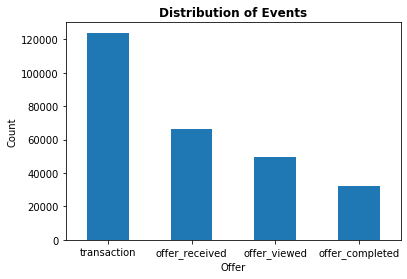

In [177]:
df.event.value_counts().plot.bar()
plt.xticks(rotation=0)
plt.xlabel('Offer')
plt.ylabel('Count')
plt.title('Distribution of Events',fontweight='bold')

Text(0.5, 1.0, 'Distribution of Offer Types')

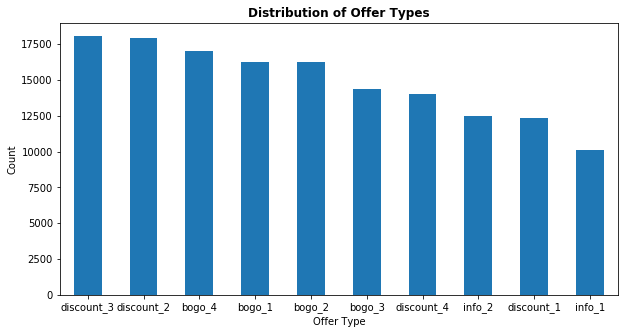

In [178]:
df.offer_name.value_counts().plot.bar(figsize=(10,5))
plt.xticks(rotation=0)
plt.xlabel('Offer Type')
plt.ylabel('Count')
plt.title('Distribution of Offer Types',fontweight='bold')

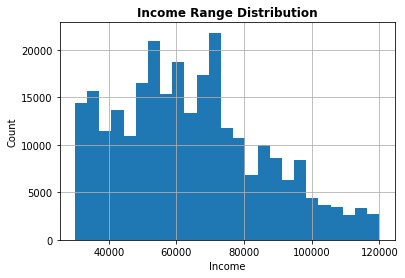

In [179]:
df.income.hist(bins = 25);
plt.xlabel('Income')
plt.ylabel('Count')
plt.title('Income Range Distribution', fontweight='bold');

In [180]:
df.income.describe()

count    272762.000000
mean      64337.000755
std       21243.762941
min       30000.000000
25%       48000.000000
50%       62000.000000
75%       78000.000000
max      120000.000000
Name: income, dtype: float64

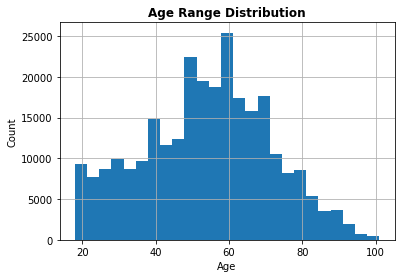

In [181]:
df.age.hist(bins = 25);
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Range Distribution', fontweight='bold');

In [182]:
df.age.median()

55.0

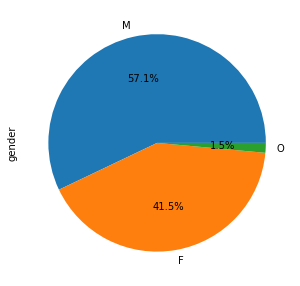

In [183]:
df.gender.value_counts().plot(kind='pie' , figsize=(5, 5), autopct='%1.1f%%')

Text(0.5, 1.0, 'Rewards Member Sign Up Year')

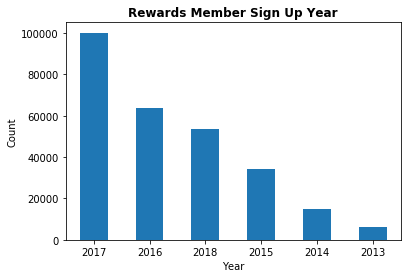

In [184]:
df.year_joined.value_counts().plot.bar()
plt.xlabel('Year')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.title('Rewards Member Sign Up Year', fontweight='bold')

In [185]:
df.groupby('year_joined')['offer_received','offer_viewed','offer_completed'].mean()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,offer_received,offer_viewed,offer_completed
year_joined,,,
2013,0.200720,0.149476,0.091847
2014,0.201751,0.153298,0.089644
2015,0.207734,0.156193,0.125483
2016,0.211468,0.161401,0.139644
2017,0.250889,0.187919,0.121016
2018,0.308998,0.227888,0.097265


Text(0.5, 1.0, 'Offer Completion % By Gender')

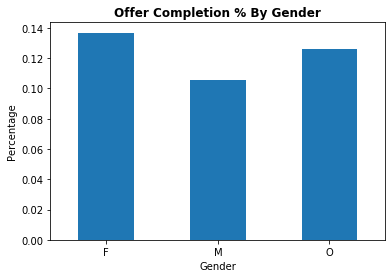

In [186]:
gender = df.groupby('gender')['offer_completed'].mean()
gender.plot(kind='bar')
plt.xticks(rotation=0)
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.title('Offer Completion % By Gender', fontweight='bold')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Offer Effectiveness')

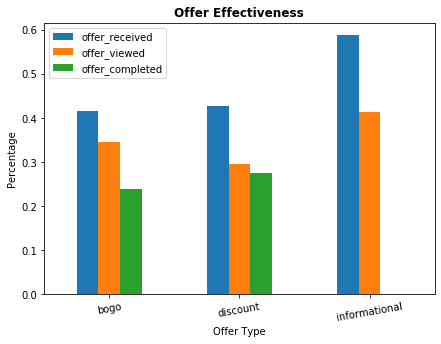

In [187]:
effect = df.groupby('offer_type')['offer_received','offer_viewed','offer_completed'].mean()
effect.plot(kind='bar',figsize=(7,5))
plt.xlabel('Offer Type')
plt.xticks(rotation=10)
plt.ylabel('Percentage')
plt.title('Offer Effectiveness', fontweight='bold')

In [188]:
amount_income = df.groupby('income')['amount'].mean()
amount_age = df.groupby('age')['amount'].mean()

In [189]:
gender_effect = df.groupby('gender')['offer_received','offer_viewed','offer_completed'].mean()
age_effect = df.groupby('age')['offer_received','offer_viewed','offer_completed'].mean()
income_effect = df.groupby('income')['offer_received','offer_viewed','offer_completed'].mean()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


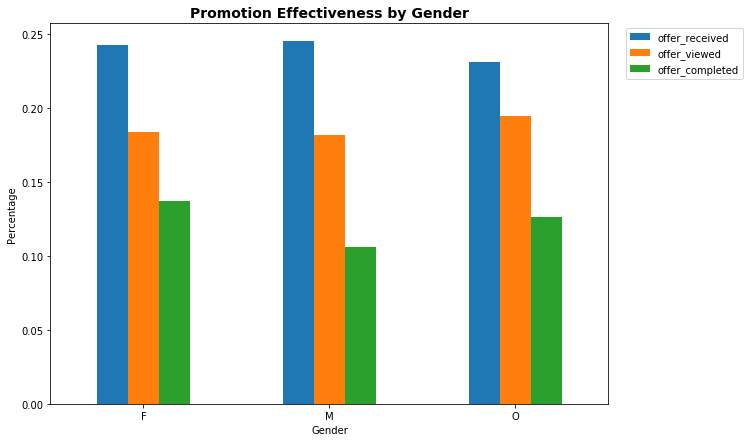

In [190]:
gender_effect.plot(kind='bar', figsize=(10,7))
plt.xlabel('Gender')
plt.xticks(rotation=0)
plt.ylabel('Percentage')
plt.title('Promotion Effectiveness by Gender', fontsize=14, fontweight='bold')
plt.legend( loc = 'upper right',  bbox_to_anchor=(1.25, 1), ncol=1)

Text(0.5, 1.0, 'Average Purchase Amount By Income Level')

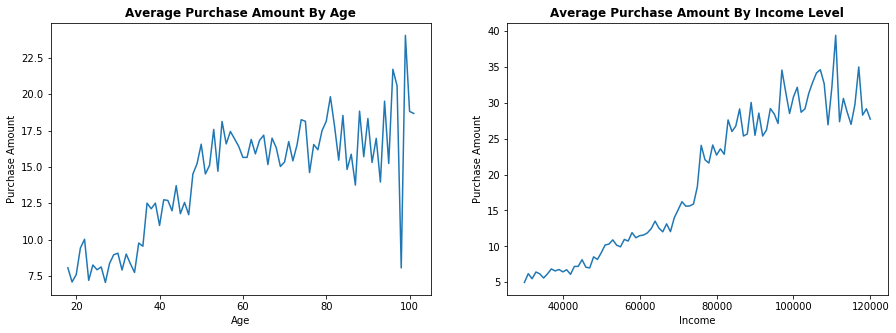

In [191]:
plt.subplot(1,2,1)
amount_age.plot(kind='line', figsize=(15,5))
plt.xticks(rotation=0)
plt.xlabel('Age')
plt.ylabel('Purchase Amount')
plt.title('Average Purchase Amount By Age', fontweight='bold')

plt.subplot(1,2,2)
amount_income.plot(kind='line', figsize=(15,5))
plt.xticks(rotation=0)
plt.xlabel('Income')
plt.ylabel('Purchase Amount')
plt.title('Average Purchase Amount By Income Level', fontweight='bold')

### Average Purchase Amount Trends

**In general, older and higher-income groups tend to spend more per purchase.**

**There is likely high correlation/crossover between these 2 groups.**

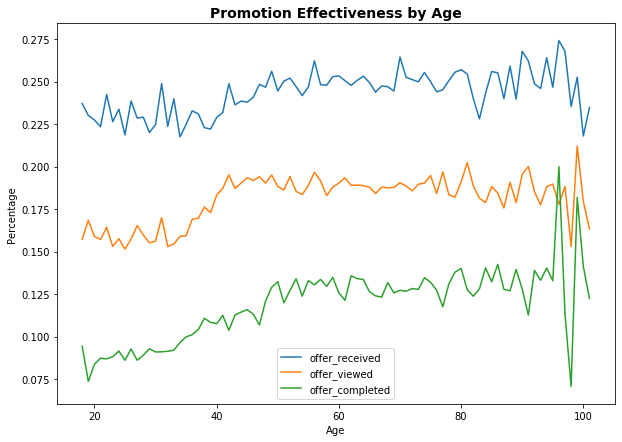

In [192]:
age_effect.plot(kind='line', figsize=(10,7))
plt.xlabel('Age')
plt.ylabel('Percentage')
plt.title('Promotion Effectiveness by Age', fontsize=14, fontweight='bold')
plt.legend( loc = 'lower center', ncol=1)

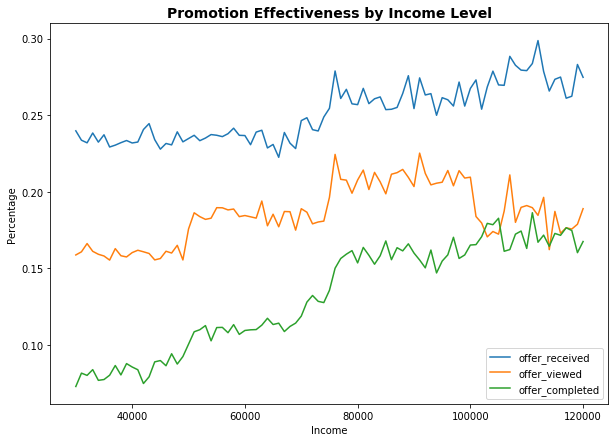

In [193]:
income_effect.plot(kind='line', figsize=(10,7))
plt.xlabel('Income')
plt.ylabel('Percentage')
plt.title('Promotion Effectiveness by Income Level', fontsize=14, fontweight='bold')
plt.legend( loc = 'lower right', ncol=1)

In [194]:
df['became_member_on'] = pd.to_datetime(df['became_member_on'], format='%Y-%m-%d')
df['membership_year'] = df['became_member_on'].dt.year
df.head()

,gender,age,user_id,became_member_on,income,20s,30s,40s,50s,60s,...,bogo_3,bogo_4,discount_1,discount_2,discount_3,discount_4,info_1,info_2,event_id,membership_year
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,2017
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,2017
2,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,2017
3,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,2017
4,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,2017


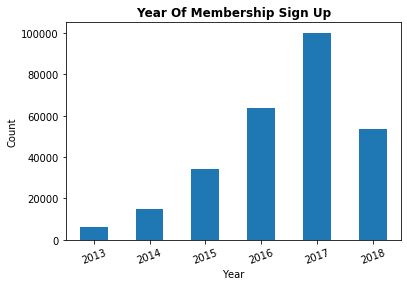

In [195]:
member = df.groupby('membership_year').count()['user_id']
member.plot(kind = 'bar')
plt.title('Year Of Membership Sign Up', fontweight='bold')
plt.xlabel('Year')
plt.xticks(rotation=20)
plt.ylabel('Count')
plt.show()

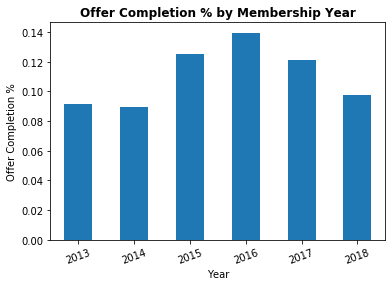

In [196]:
member = df.groupby('membership_year')['offer_completed'].mean()
member.plot(kind = 'bar')
plt.title('Offer Completion % by Membership Year', fontweight='bold')
plt.xlabel('Year')
plt.xticks(rotation=20)
plt.ylabel('Offer Completion %')
plt.show()

In [197]:
df.groupby('membership_year')['income','offer_completed','age'].mean()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,income,offer_completed,age
membership_year,,,
2013,56259.823183,0.091847,51.276850
2014,56864.820847,0.089644,50.230252
2015,65061.826317,0.125483,53.768035
2016,68169.721901,0.139644,55.891732
2017,64900.852772,0.121016,53.801765
2018,61210.703656,0.097265,52.794893


## Prepping Data for Modelling

In [198]:
df_pred = df.copy()

In [199]:
df_pred.sort_values(by=['user_id','time_hours'])

,gender,age,user_id,became_member_on,income,20s,30s,40s,50s,60s,...,bogo_3,bogo_4,discount_1,discount_2,discount_3,discount_4,info_1,info_2,event_id,membership_year
60071,M,33,0009655768c64bdeb2e877511632db8f,2017-04-21,72000.0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,2017
60072,M,33,0009655768c64bdeb2e877511632db8f,2017-04-21,72000.0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,3,2017
60073,M,33,0009655768c64bdeb2e877511632db8f,2017-04-21,72000.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2017
60074,M,33,0009655768c64bdeb2e877511632db8f,2017-04-21,72000.0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,2017
60075,M,33,0009655768c64bdeb2e877511632db8f,2017-04-21,72000.0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,3,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30173,F,45,ffff82501cea40309d5fdd7edcca4a07,2016-11-25,62000.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2016
30174,F,45,ffff82501cea40309d5fdd7edcca4a07,2016-11-25,62000.0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,2,2016
30175,F,45,ffff82501cea40309d5fdd7edcca4a07,2016-11-25,62000.0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,3,2016
30176,F,45,ffff82501cea40309d5fdd7edcca4a07,2016-11-25,62000.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2016


In [200]:
df_pred.reset_index(inplace=True)

In [201]:
df_pred.drop(columns=['index'], inplace=True)

In [202]:
df_pred.head()

,gender,age,user_id,became_member_on,income,20s,30s,40s,50s,60s,...,bogo_3,bogo_4,discount_1,discount_2,discount_3,discount_4,info_1,info_2,event_id,membership_year
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,2017
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,2017
2,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,2017
3,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,2017
4,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,2017


In [203]:
df_pred['offer_transaction'] = df_pred['offer_completed'].shift(-1)
df_pred['unviewed_transaction'] = df_pred['offer_viewed'].shift(+1)
df_pred.head()

,gender,age,user_id,became_member_on,income,20s,30s,40s,50s,60s,...,discount_1,discount_2,discount_3,discount_4,info_1,info_2,event_id,membership_year,offer_transaction,unviewed_transaction
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,0,0,0,0,0,0,0,2017,0.0,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,0,0,0,0,0,0,0,2017,0.0,0.0
2,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,0,0,0,0,0,0,1,2017,0.0,0.0
3,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,0,0,0,0,1,0,1,2017,0.0,0.0
4,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,0,0,0,0,0,0,0,2017,1.0,0.0


In [204]:
df_pred.offer_name.fillna(method='ffill', inplace=True)

In [205]:
df_pred.offer_name

0            NaN
1            NaN
2         bogo_3
3         info_1
4         info_1
           ...  
272757    bogo_4
272758    bogo_4
272759    bogo_4
272760    info_1
272761    info_1
Name: offer_name, Length: 272762, dtype: object

In [206]:
df_pred['unviewed_completion'] = df_pred['unviewed_transaction'] + df_pred['offer_transaction']
df_pred.head()

,gender,age,user_id,became_member_on,income,20s,30s,40s,50s,60s,...,discount_2,discount_3,discount_4,info_1,info_2,event_id,membership_year,offer_transaction,unviewed_transaction,unviewed_completion
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,0,0,0,0,0,0,2017,0.0,NaN,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,0,0,0,0,0,0,2017,0.0,0.0,0.0
2,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,0,0,0,0,0,1,2017,0.0,0.0,0.0
3,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,0,0,0,1,0,1,2017,0.0,0.0,0.0
4,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,0,1,0,...,0,0,0,0,0,0,2017,1.0,0.0,1.0


In [207]:
unviewed_completions = df_pred[df_pred['unviewed_completion']==2]
unviewed_completions.head()

,gender,age,user_id,became_member_on,income,20s,30s,40s,50s,60s,...,discount_2,discount_3,discount_4,info_1,info_2,event_id,membership_year,offer_transaction,unviewed_transaction,unviewed_completion
8,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,0,0,0,0,0,...,0,0,0,0,0,0,2017,1.0,1.0,2.0
33,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,0,0,0,0,1,...,0,0,0,0,0,0,2018,1.0,1.0,2.0
38,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,0,0,0,0,1,...,0,0,0,0,0,0,2018,1.0,1.0,2.0
46,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,0,0,0,0,1,...,0,0,0,0,0,0,2018,1.0,1.0,2.0
53,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,0,0,0,0,1,...,0,0,0,0,0,0,2018,1.0,1.0,2.0


In [208]:
unviewed_completions.describe()

,age,income,20s,30s,40s,50s,60s,70s,80s,90s,...,discount_2,discount_3,discount_4,info_1,info_2,event_id,membership_year,offer_transaction,unviewed_transaction,unviewed_completion
count,16797.000000,16797.000000,16797.000000,16797.000000,16797.000000,16797.000000,16797.000000,16797.000000,16797.000000,16797.000000,...,16797.0,16797.0,16797.0,16797.0,16797.0,16797.0,16797.000000,16797.0,16797.0,16797.0
mean,57.151098,72625.052093,0.049890,0.078288,0.162827,0.266595,0.219682,0.131273,0.064416,0.020123,...,0.0,0.0,0.0,0.0,0.0,0.0,2016.450735,1.0,1.0,2.0
std,15.929625,20442.608658,0.217724,0.268632,0.369218,0.442192,0.414044,0.337709,0.245500,0.140424,...,0.0,0.0,0.0,0.0,0.0,0.0,1.067123,0.0,0.0,0.0
min,18.000000,30000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,2013.000000,1.0,1.0,2.0
25%,47.000000,57000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,2016.000000,1.0,1.0,2.0
50%,57.000000,72000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,2017.000000,1.0,1.0,2.0
75%,68.000000,87000.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,2017.000000,1.0,1.0,2.0
max,101.000000,120000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,2018.000000,1.0,1.0,2.0


In [218]:
viewed_transaction = df_pred[(df_pred['unviewed_completion']!=2) & (df_pred['offer_transaction']==1)]
non_offer_transactions = df_pred[(df_pred['unviewed_completion']==1) & (df_pred['unviewed_transaction']==1)]

In [219]:
viewed_transaction.shape[0]

15647

In [220]:
total_transactions = df_pred[df_pred['event']=='transaction'].shape[0]
num_unviewed_completions = unviewed_completions.shape[0]
num_viewed_completions = viewed_transaction.shape[0]
num_non_trans = non_offer_transactions.shape[0]

Text(0.5, 1.0, 'Breakdown of All Transactions')

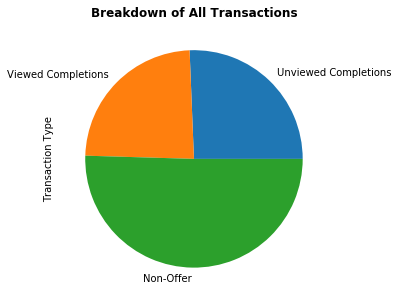

In [221]:
df_transactions = pd.DataFrame({'Transaction Type': [num_unviewed_completions, num_viewed_completions , num_non_trans]},
                  index=['Unviewed Completions', 'Viewed Completions', 'Non-Offer'])
plot = df_transactions.plot.pie(y='Transaction Type', figsize=(5, 5), legend = None)
plt.title('Breakdown of All Transactions', fontweight='bold')

In [222]:
unviewed_completions.shape[0]/ df_pred[df_pred['event']=='transaction'].shape[0] * 100

13.550666763474432

In [223]:
unviewed_completions.shape[0], viewed_transaction.shape[0], non_offer_transactions.shape[0]

(16797, 15647, 33063)

In [224]:
unviewed_completions.shape[0], viewed_transaction.shape[0]

(16797, 15647)

In [226]:
non_offer_sum = non_offer_transactions[['age','income','female','male','other','amount']].mean()
non_viewed_offer_sum = unviewed_completions[['age','income','female','male','other','amount']].mean()
offer_sum = viewed_transaction[['age','income','female','male','other','amount']].mean()

In [227]:
df_sums = pd.concat([non_offer_sum, offer_sum, non_viewed_offer_sum], join="inner", axis =1)

In [228]:
df_sums.columns = ['non_offer', 'viewed_offer','unviewed']

In [229]:
df_sums

,non_offer,viewed_offer,unviewed
age,53.165109,54.404806,57.151098
income,62013.912833,66001.789480,72625.052093
female,0.372924,0.453314,0.499137
male,0.613435,0.534479,0.482408
other,0.013641,0.012207,0.018456
amount,10.000422,18.341809,22.139314


In [230]:
high_income_unviewed_completions = unviewed_completions[unviewed_completions['income']>=100000]
low_income_unviewed_completions = unviewed_completions[unviewed_completions['income']<=35000]
high_income_viewed_completions = viewed_transaction[viewed_transaction['income']>=100000]
low_income_viewed_completions = viewed_transaction[viewed_transaction['income']<=35000]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

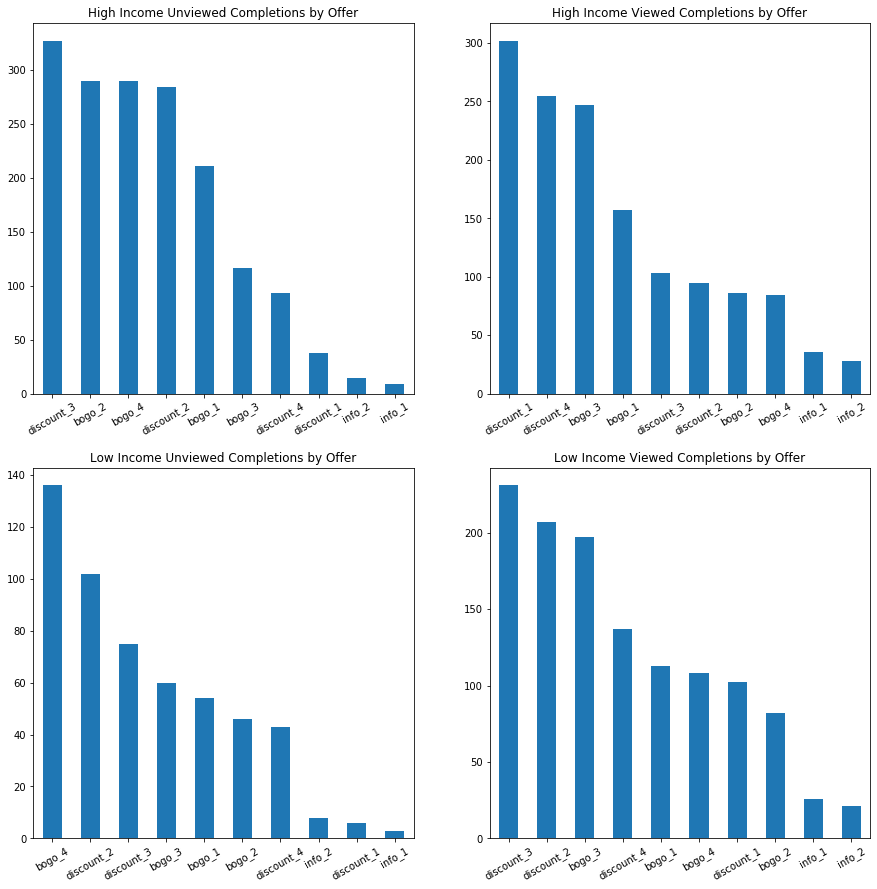

In [231]:
plt.subplot(2,2,1)
high_income_unviewed_completions.offer_name.value_counts().plot.bar()
plt.title('High Income Unviewed Completions by Offer')
plt.xticks(rotation=30)

plt.subplot(2,2,3)
low_income_unviewed_completions.offer_name.value_counts().plot.bar(figsize=(15,15))
plt.title('Low Income Unviewed Completions by Offer')
plt.xticks(rotation=30)


plt.subplot(2,2,2)
high_income_viewed_completions.offer_name.value_counts().plot.bar()
plt.title('High Income Viewed Completions by Offer')
plt.xticks(rotation=30)


plt.subplot(2,2,4)
low_income_viewed_completions.offer_name.value_counts().plot.bar(figsize=(15,15))
plt.title('Low Income Viewed Completions by Offer')
plt.xticks(rotation=30)


In [250]:
female_viewed_completions = viewed_transaction[viewed_transaction['gender']<='F']
male_viewed_completions = viewed_transaction[viewed_transaction['gender']<='M']

female_unviewed_completions = unviewed_completions[unviewed_completions['gender']<='F']
male_unviewed_completions = unviewed_completions[unviewed_completions['gender']<='M']

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

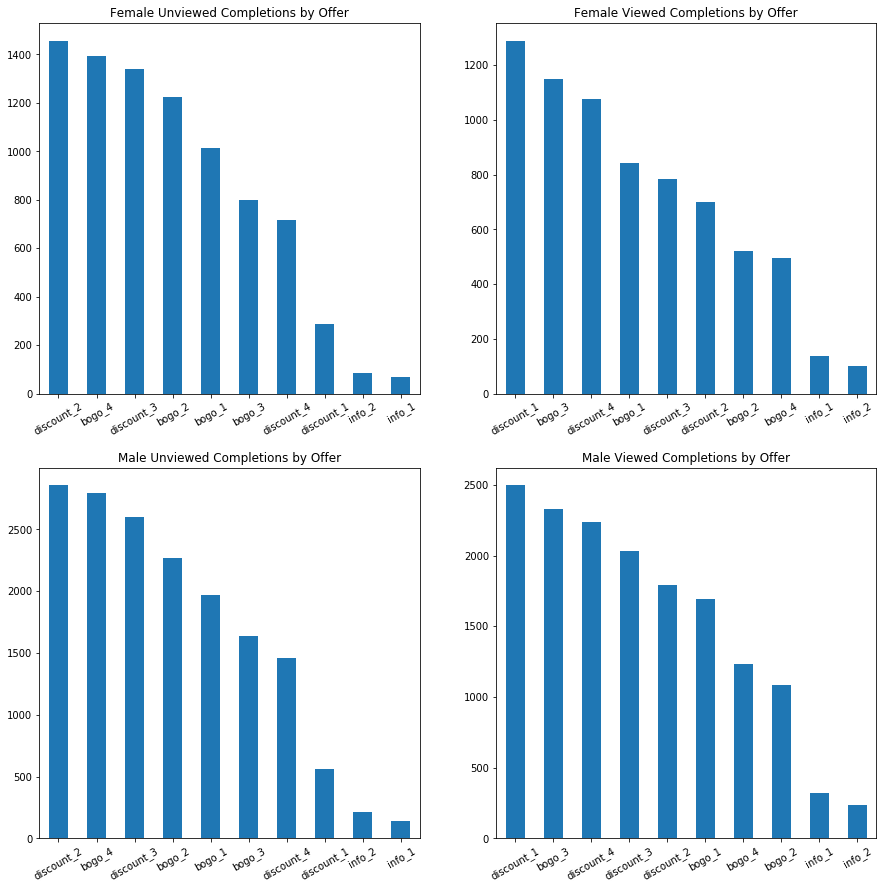

In [251]:
plt.subplot(2,2,1)
female_unviewed_completions.offer_name.value_counts().plot.bar()
plt.title('Female Unviewed Completions by Offer')
plt.xticks(rotation=30)

plt.subplot(2,2,3)
male_unviewed_completions.offer_name.value_counts().plot.bar(figsize=(15,15))
plt.title('Male Unviewed Completions by Offer')
plt.xticks(rotation=30)


plt.subplot(2,2,2)
female_viewed_completions.offer_name.value_counts().plot.bar()
plt.title('Female Viewed Completions by Offer')
plt.xticks(rotation=30)


plt.subplot(2,2,4)
male_viewed_completions.offer_name.value_counts().plot.bar(figsize=(15,15))
plt.title('Male Viewed Completions by Offer')
plt.xticks(rotation=30)

In [232]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


**40% of unviewed completions are coming from the top 25% of income earners.**

In [233]:
unviewed_completions.shape[0]

16797

In [234]:
viewed_transaction[['age','income','female','male','other']].mean()

age          54.404806
income    66001.789480
female        0.453314
male          0.534479
other         0.012207
dtype: float64

Text(0, 0.5, 'Count')

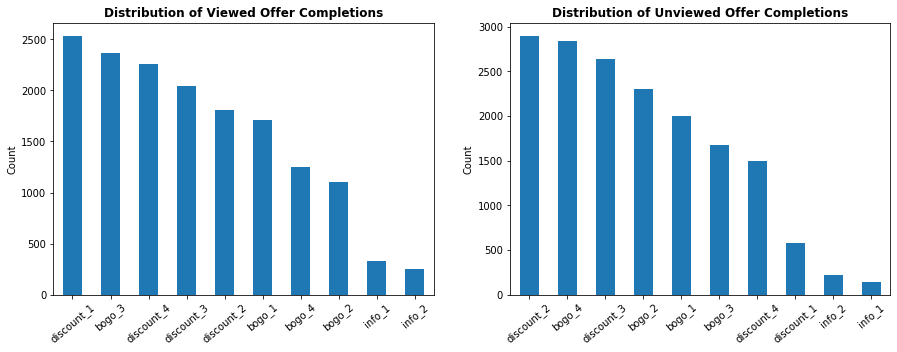

In [235]:
plt.subplot(1,2,1)
viewed_transaction.offer_name.value_counts().plot(kind='bar')
plt.title('Distribution of Viewed Offer Completions', fontweight='bold')
plt.xticks(rotation=40)
plt.ylabel('Count')

plt.subplot(1,2,2)
unviewed_completions.offer_name.value_counts().plot(kind='bar', figsize=(15,5))
plt.title('Distribution of Unviewed Offer Completions', fontweight='bold')
plt.xticks(rotation=40)
plt.ylabel('Count')

**From this analysis I would have a serious look at both bogo_4 and discount_2**

You would have to evaluate **whether the minimal increase in sales from these offers is negligible** compared to the amount of unviewed completions these offers tend to have. 

Bogo 4 and Discount 2 happen to be the easiest offers to complete in their respective categories

**13% of all transactions in the dataset are unviewed offer completions.**

**52% of all offer completions occur without the user ever viewing the offer.**